In [1]:
import cv2
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import moviepy.editor as mpy

In [2]:
mtx = np.array([[1.15777942e+03, 0.00000000e+00, 6.67111050e+02],
       [0.00000000e+00, 1.15282305e+03, 3.86129068e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist = np.array([[-0.24688832, -0.02372817, -0.00109843,  0.00035105, -0.00259133]])

In [3]:
def vidRead(vidtype, path ="/home/gokul/Projects/LaneDetection/Input/"):
    imgs = []
    if vidtype == 'Challenge':
        video = path + 'challenge_video.mp4'
    elif vidtype == 'Project':
        video = path + 'project_video.mp4'
    else:
        print('Improper video type')
    cap = cv2.VideoCapture(video)
    while(True):
        ret, frame = cap.read()
        if ret:
            frame =  cv2.undistort(frame, mtx, dist, None, mtx)
            imgs.append(frame)
        else:
            break
    cap.release()
    
    return imgs

imgs = vidRead('Challenge')

KeyboardInterrupt: 

In [4]:
len(imgs)

481

Simple Model - Failedd

# Advanced Lane Detector

#### Functions Till now:

In [5]:

im = imgs[500]

outputFrame = processLane(im)
plt.imshow(outputFrame)

NameError: name 'imgs' is not defined

# Steps:

Do undistortion:

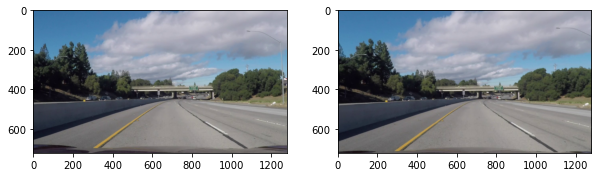

In [6]:
cap = cv2.VideoCapture('/home/gokul/Projects/LaneDetection/Input/challenge_video.mp4')
ret, im = cap.read()
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im_undistort =  cv2.undistort(im, mtx, dist, None, mtx)

fx,plts = plt.subplots(1,2,figsize=(10,5))
plts[0].imshow(im)
plts[1].imshow(im_undistort)

### Find Color threshold

For HLS color picker: https://www.w3schools.com/colors/colors_hsl.asp

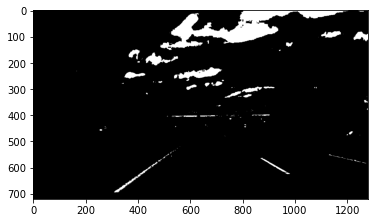

In [7]:
imHLS = cv2.cvtColor(im, cv2.COLOR_RGB2HLS)
# imHLS = cv2.cvtColor(imgs[1000], cv2.COLOR_BGR2HLS)

# White-ish areas in image
# H value can be arbitrary, thus within [0 ... 360] (OpenCV: [0 ... 180])
# L value must be relatively high (we want high brightness), e.g. within [0.7 ... 1.0] (OpenCV: [0 ... 255])
# S value must be relatively low (we want low saturation), e.g. within [0.0 ... 0.3] (OpenCV: [0 ... 255])
white_lower = np.array([np.round(  0 / 2), np.round(0.75 * 255), np.round(0.00 * 255)])
white_upper = np.array([np.round(360 / 2), np.round(1.00 * 255), np.round(1.00 * 255)])
white_mask = cv2.inRange(imHLS, white_lower, white_upper)

# Yellow-ish areas in image
# H value must be appropriate (see HSL color space), e.g. within [40 ... 60]
# L value can be arbitrary (we want everything between bright and dark yellow), e.g. within [0.0 ... 1.0]
# S value must be above some threshold (we want at least some saturation), e.g. within [0.35 ... 1.0]
yellow_lower = np.array([np.round( 40 / 2), np.round(0.3 * 255), np.round(0.4 * 255)])
yellow_upper = np.array([np.round( 70 / 2), np.round(1.00 * 255), np.round(1.00 * 255)])
yellow_mask = cv2.inRange(imHLS, yellow_lower, yellow_upper)

# Calculate combined mask, and masked image
mask = cv2.bitwise_or(yellow_mask, white_mask)
# masked = cv2.bitwise_and(input, input, mask = mask)
plt.imshow(mask,'gray')

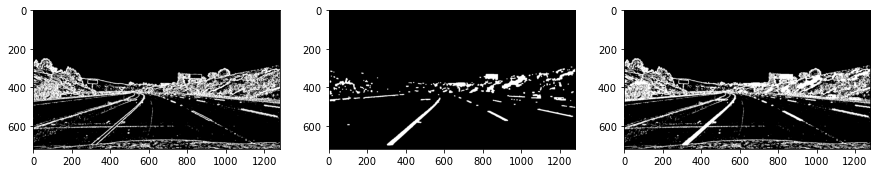

In [6]:
# See color and edge thresolded maps
img = imgs[0]
sobel_output = sobelEdgeThresholding(img ,t1 = 30,t2=255,mt1 = 30,mt2 = 255,dt1 = 45*np.pi/180 ,dt2 = 65*np.pi/180)
colorMask = ColorThreshold(img)
edges = cv2.bitwise_or(sobel_output,colorMask)

fx,plts = plt.subplots(1,3,figsize=(15,5))
plts[0].imshow(sobel_output,'gray')
plts[1].imshow(colorMask,'gray')
plts[2].imshow(edges,'gray')

## Perspective Transform

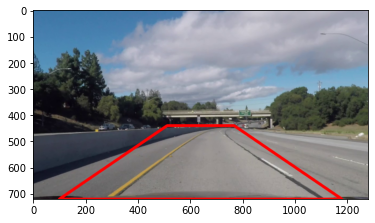

In [9]:
# define the lane region trapezoid
im1 = np.copy(im_undistort)
height,width = im1.shape[:2]
a = 100
horizon = 440
b = 0.4
pts = np.array([[a,height],[int(width*b),horizon],[int(width*(1-b)),horizon], [width-a, height]], np.int32)
cv2.polylines(im1,[pts],True,(255,0,0), 10)
plt.imshow(im1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


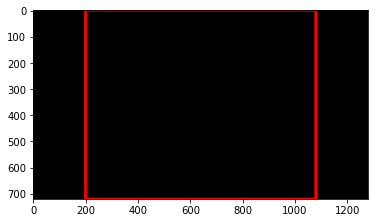

In [10]:
# define the rectangular bird's eye transform
res = np.array([[(a+100), height], [(a+100), 0], [width-(a+100), 0], [width-(a+100), height]], np.int32)
bg = np.zeros(im.shape)
cv2.polylines(bg,[res],True,(255,0,0), 10)
plt.imshow(bg)

### Find Lane curves:

396 1113


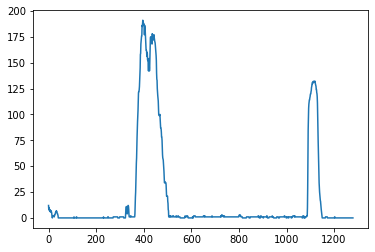

In [13]:
# find bottom start locations
im = imgs[780]

sobel_output = sobelEdgeThresholding(im ,t1 = 125,t2=255,mt1 = 125,mt2 = 255,dt1 = 45*np.pi/180 ,dt2 = 65*np.pi/180)
colorMask = ColorThreshold(im)
im_binary  = cv2.bitwise_or(sobel_output,colorMask)

im_warp = getPerspectiveTransform(im_binary)
height,width = im_warp.shape[:2]
half_height = int(im_warp.shape[0]//2) # divide the height by 2
half_width = int(im_warp.shape[1]//2) # divide the width by 2
im_warpBOTTOM = im_warp[half_height:,:] # find bottom half of the warped road
distribution = np.sum(im_warpBOTTOM,axis=0) # plot the pixel distribution along x axis
#or
im_warpTOP = im_warp[:half_height,:] # find bottom half of the warped road
distribution = np.sum(im_warpBOTTOM,axis=0) # plot the pixel distribution along x axis
im_warpLEFT = im_warp[:,:half_width] # find bottom half of the warped road
im_warpRIGHT = im_warp[:,half_width:] # find bottom half of the warped road

mdpt = int(len(distribution)//2) # find midpoint of the distribution alonf x axis
p1 = np.argmax(distribution[:mdpt]) # find left lane peak as p1
p2 = np.argmax(distribution[mdpt:])+mdpt # find right lane peak as p2 
print(p1,p2)
plt.plot(distribution)

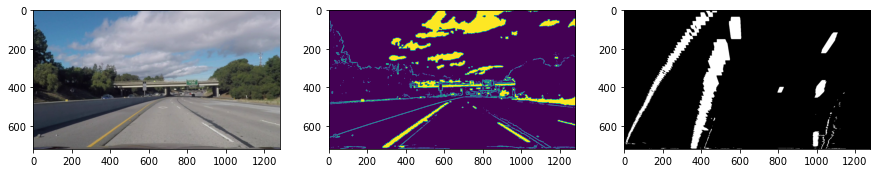

In [20]:
im = imgs[30]

sobel_output = sobelEdgeThresholding(im ,t1 = 125,t2=255,mt1 = 125,mt2 = 255,dt1 = 45*np.pi/180 ,dt2 = 65*np.pi/180)
colorMask = ColorThreshold(im)
im_binary  = cv2.bitwise_or(sobel_output,colorMask)
# im_binary = colorMask
im_warp = getPerspectiveTransform(im_binary,a=200,b=0.46,horizon=470)

fx,plts = plt.subplots(1,3,figsize=(15,5))
plts[0].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plts[1].imshow(im_binary)
plts[2].imshow(im_warp,'gray')

## How to Find Lane Curvature and angles

In [14]:
Lanex = (np.squeeze(L_line)[:,0] + np.squeeze(R_line)[:,0])//2
Laney = (np.squeeze(L_line)[:,1] + np.squeeze(R_line)[:,1])//2

# Line = np.dstack((Lanex,Laney))

curveDir = np.poly1d(np.polyfit(Laney,Lanex,1))
yaxis = np.linspace(Laney.min(),Laney.max()-1)
linefit = curveDir(yaxis)
line = np.dstack((linefit.astype(np.int32),yaxis.astype(np.int32)))

slope = (linefit[-1] - linefit[0]) / (yaxis[-1] - yaxis[0])

if  slope > 0.1:
    direction = 'left'
elif  (slope > 0.01) & (slope < 0.1):
    direction = 'slight left'

elif slope < -0.1 :
    direction = 'right'
elif  (slope > -0.1) & (slope < -0.01):
    direction = 'slight right'

else:
    direction = 'straight'

print(slope,direction)


0.2799194633453519 left


# Find lanes - Work HERE

750.3892673364273 1122.7896090825013 -0.29137500000000005 slight right


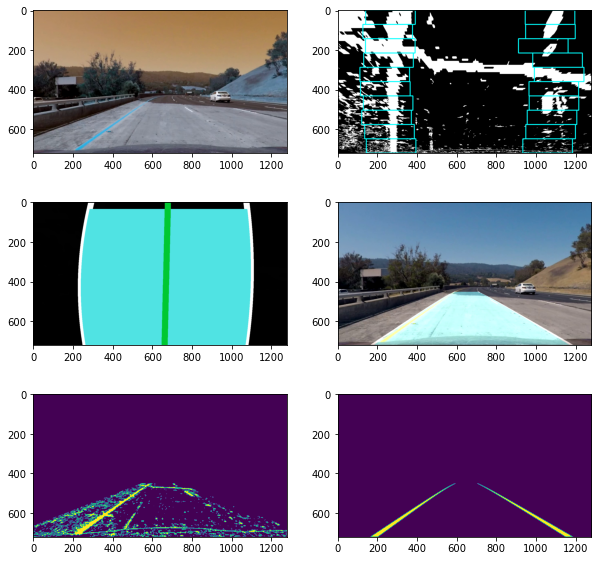

In [77]:
im = imgs[600]
sobel_output = sobelEdgeThresholding(im ,t1 = 30,t2=255,mt1 = 30,mt2 = 255,dt1 = 45*np.pi/180 ,dt2 = 65*np.pi/180)
colorMask = ColorThreshold(im)
im_binary  = cv2.bitwise_or(sobel_output,colorMask)
# im_binary = colorMask

im_warp = getPerspectiveTransform(im_binary)
[lX,lY],[rX,rY], window_img = windowTrace(im_warp)
L_line, R_line = fitLaneCurves(lX,lY,rX,rY)
imLines = drawLaneLines(im_warp,L_line,R_line) # draw the estimated lane line 
line,direction = getDirection(L_line,R_line) # get the center line with mean of left and right lanes

inv_imLines1 = getPerspectiveTransform(imLines,True)# get the unwarped estimated lane line 
inv_im_warp = getPerspectiveTransform(im_warp,True) # get actual unwarped lanes

# get center Line
imL = np.dstack((imLines,imLines,imLines))
inv_imColorLane = drawLaneArea(imL,L_line,R_line)  
imL = cv2.polylines(imL, [line], False,  (0,200, 50), 30)

LeftCurveRadius,RightCurveRadius,RealLaneCenterOffset = getLaneStats(L_line,R_line)

print(LeftCurveRadius,RightCurveRadius,RealLaneCenterOffset,direction )

fx,plts = plt.subplots(3,2,figsize=(10,10))
plts[0][0].imshow(im)
plts[0][1].imshow(window_img)
plts[1][0].imshow(imL)
plts[1][1].imshow(inv_imColorLane)
plts[2][0].imshow(inv_im_warp)
plts[2][1].imshow(inv_imLines1)

In [15]:
# Lane DetectorClass

In [ ]:
class LaneDetector():
    def __init__(self,unDistCoeffs,window_width=200):
        self.mtx = unDistCoeffs[0]
        self.dist = unDistCoeffs[1]
        self.widow_width = window_width
        
        self.outputs= []
        
    
    def fit(self,path):
        cap = cv2.VideoCapture(path)
        while(True):
            ret, frame = cap.read()
            if ret:
    #             frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                frame =  cv2.undistort(frame, self.mtx, self.dist, None, self.mtx)
                frame = processLane(frame)
                self.outputs.append(frame)
            else:
                break
    
    def processLane(self,im):
        
        im_binary = ColorThreshold(im)  #get the yellow and white lanes

        im_warp = getPerspectiveTransform(im_binary) # get the bird's eye view of the road - denoted as Bmap

        height,width = im_warp.shape[:2]
        half_height = int(im_warp.shape[0]//2) # divide the height by 2
        half_width = int(im_warp.shape[1]//2) # divide the height by 2

        im_warpTOP = im_warp[:half_height,:] # find bottom half of the Bmap
        im_warpBOTTOM = im_warp[half_height:,:] # find bottom half of the Bmap

        # Split the Bmap to upper and lower halves and Find the centroids points by traversing a sliding window in the lane curve.  
        L_centrdsTOP,R_centrdsTOP = windowTrace(im_warpTOP,10,self.window_width)
        L_centrdsBOTTOM,R_centrdsBOTTOM = windowTrace(im_warpBOTTOM,10,self.window_width)

        # The split resulted in a Y height of (0-360) for bottom Bmap, instead of (360-720). compensate the bottom range by adding an offset of 360 to Y axis
        L_centrdsBOTTOM,R_centrdsBOTTOM = [(i,j+half_height) for (i,j) in L_centrdsBOTTOM],[(i,j+half_height) for (i,j) in R_centrdsBOTTOM]

        # Append the top and bottom centroids to get the total list of centroids of the entire Bmap
        L_centrds, R_centrds = np.vstack((np.array(L_centrdsBOTTOM),np.array(L_centrdsTOP[1:]))), np.vstack((np.array(R_centrdsBOTTOM),np.array(R_centrdsTOP[1:])))

        # get 3rd degree polynomial coefficients for a line fit through the centroid points along the Y axis ie {np.polyfit(Y,X)}
        left_curve, right_curve = np.poly1d(np.polyfit(L_centrds[:,1],L_centrds[:,0],3)), np.poly1d(np.polyfit(R_centrds[:,1],R_centrds[:,0],3))
        # specify the linear range/space for the polynomial line
        Laxis,Raxis = np.linspace(L_centrds[:,1].min(),L_centrds[:,1].max()-1), np.linspace(R_centrds[:,1].min(),R_centrds[:,1].max()-1)
        # fit the polynomial coefficents with the linear space
        l_fit,r_fit = left_curve(Laxis),right_curve(Raxis)


        L_line, R_line = np.dstack((l_fit.astype(np.int32),Laxis.astype(np.int32))), np.dstack((r_fit.astype(np.int32),Raxis.astype(np.int32)))


        # Visualisation works 

        line = getDirection(L_line,R_line) # get the center line with mean of left and right lanes.
        imLines = drawLaneLines(im_warp,L_line,R_line) # draw the estimated lane line 

        inv_imLines1 = getPerspectiveTransform(imLines,True)# get the unwarped estimated lane line 
        inv_im_warp = getPerspectiveTransform(im_warp,True) # get actual unwarped lanes

        # get center Line
        imL = np.dstack((imLines,imLines,imLines))
        imL = cv2.polylines(imL, [line], False,  (0,200, 50), 30)
        ## get lane area in green


        imLines = np.dstack((imLines,imLines,imLines))
        l1,r1 = L_line[0][35:],np.flipud(R_line[0][35:]) # get the last 15 points of left and right lines in right order
        pts = np.vstack((l1,r1)) # stack then in correct order
        imColorLane = cv2.fillPoly(imLines, [pts], (80,227, 227)) #get ColorLanes

        inv_imColorLane = getPerspectiveTransform(imColorLane,True)
        
        inv_imColorLane = cv2.addWeighted(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), 1, inv_imColorLane, 0.5, 0)
        
        return inv_imColorLane
    
    def predict():
        
        return video

In [23]:
class LaneDetector():
    def __init__(self,unDistCoeffs,window_width=200):
        self.mtx = unDistCoeffs[0]
        self.dist = unDistCoeffs[1]
        self.widow_width = window_width
        self.prevL_line = None
        self.prevR_line = None
        
        self.outputs= []

    # color based thresholding
    def ColorThreshold(im):
        imHLS = cv2.cvtColor(im, cv2.COLOR_BGR2HLS)

        # White-ish areas in image
        # H value can be arbitrary, thus within [0 ... 360] (OpenCV: [0 ... 180])
        # L value must be relatively high (we want high brightness), e.g. within [0.7 ... 1.0] (OpenCV: [0 ... 255])
        # S value must be relatively low (we want low saturation), e.g. within [0.0 ... 0.3] (OpenCV: [0 ... 255])
        white_lower = np.array([np.round(  0 / 2), np.round(0.75 * 255), np.round(0.00 * 255)])
        white_upper = np.array([np.round(360 / 2), np.round(1.00 * 255), np.round(1.00 * 255)])
        white_mask = cv2.inRange(imHLS, white_lower, white_upper)

        # Yellow-ish areas in image
        # H value must be appropriate (see HSL color space), e.g. within [40 ... 60]
        # L value can be arbitrary (we want everything between bright and dark yellow), e.g. within [0.0 ... 1.0]
        # S value must be above some threshold (we want at least some saturation), e.g. within [0.1 ... 1.0]
        yellow_lower = np.array([np.round( 40 / 2), np.round(0.35 * 255), np.round(0.1 * 255)])
        yellow_upper = np.array([np.round( 70 / 2), np.round(1.00 * 255), np.round(1.00 * 255)])
        yellow_mask = cv2.inRange(imHLS, yellow_lower, yellow_upper)

        # Calculate combined mask, and masked image
        colorMask = cv2.bitwise_or(yellow_mask, white_mask)
        ret,colorMask = cv2.threshold(colorMask,0.5,1,cv2.THRESH_BINARY)

        kernel = np.ones((3,3),np.uint8)
        colorMask = cv2.dilate(colorMask,kernel,iterations = 2)
        colorMask = cv2.morphologyEx(colorMask, cv2.MORPH_CLOSE, kernel)

        return colorMask


    # gradient  thresholding
    def sobelEdgeThresholding(im,t1=125,t2=255,mt1 = 125,mt2 =  255,dt1 = 45*np.pi/180 ,dt2 = 65*np.pi/180):
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        sx = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)) 
        sy = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3))

        direction = np.arctan2(np.absolute(sy), np.absolute(sx))
        magnitude = cv2.magnitude(sx,sy)
        sx = np.uint8(sx) 
        sy = np.uint8(sy)

        ret,sx = cv2.threshold(sx,t1,t2,cv2.THRESH_BINARY)
        ret,sy = cv2.threshold(sy,t1,t2,cv2.THRESH_BINARY)    
        ret,magnitude = cv2.threshold(magnitude,mt1,mt2,cv2.THRESH_BINARY)
        dir_output =  np.zeros_like(direction)
        dir_output[(direction >= dt1) & (direction <= dt2)] = 1 

        sx = np.uint8(sx/255)
        sy = np.uint8(sy/255)
        magnitude = np.uint8(magnitude/255)
        sobel_output = np.zeros_like(direction, np.uint8)    
        sobel_output[((sx == 1) | (sy == 1)) & ((magnitude == 1) | (dir_output == 1))] = 1

        return sobel_output

    # to get birds eye view
    # plot the tracked lane lines in the Map
    def drawLaneLines(im_warp,L_line,R_line):

        imlines = im_warp.copy() # get a 
        im_lines = np.dstack((imlines,imlines,imlines))*255
        imlines = cv2.polylines(imlines, [L_line], False,  (255, 100,0), 30)
        imlines = cv2.polylines(imlines, [R_line], False,  (255, 100,0), 30)

        return imlines

    # Track the lane lines by in bird's eye view image to find trajectory points using centroids


    # get the direction of lane from the estimated lane trajectory
    def getDirection(L_line,R_line):

        Lanex = (np.squeeze(L_line)[:,0] + np.squeeze(R_line)[:,0])//2
        Laney = (np.squeeze(L_line)[:,1] + np.squeeze(R_line)[:,1])//2

        # Line = np.dstack((Lanex,Laney))

        curveDir = np.poly1d(np.polyfit(Laney,Lanex,1))
        yaxis = np.linspace(Laney.min(),Laney.max()-1)
        linefit = curveDir(yaxis)
        line = np.dstack((linefit.astype(np.int32),yaxis.astype(np.int32)))

        slope = (linefit[-1] - linefit[0]) / (yaxis[-1] - yaxis[0])

        if  slope > 0.1:
            direction = 'left'
        elif  (slope > 0.01) & (slope < 0.1):
            direction = 'slight left'

        elif slope < -0.1 :
            direction = 'right'
        elif  (slope > -0.1) & (slope < -0.01):
            direction = 'slight right'

        else:
            direction = 'straight'

    #     print(slope,direction)

        return line,direction

    def getPerspectiveTransform(im,inverse=False,a=100,horizon = 450,b=0.45):
        im_warp = np.copy(im)
        height,width = im.shape[:2]

        pts = np.array([[a,height],[int(width*b),horizon],[int(width*(1-b)),horizon], [width-a, height]], np.float32)
        res = np.array([[(a+100), height], [(a+100), 0], [width-(a+100), 0], [width-(a+100), height]], np.float32)
    #     res = np.array([[a, height], [a, 0], [width-a, 0], [width-a, height]], np.float32) 

        if inverse == True:
            M = cv2.getPerspectiveTransform(res, pts)
        else:   
            M = cv2.getPerspectiveTransform(pts, res)

        im_warp = cv2.warpPerspective(im_warp, M, (width,height), flags=cv2.INTER_LINEAR)

        return im_warp
    def windowTrace(im_warp):
        height,width = im_warp.shape[:2]
        distribution  = np.sum(im_warp[height//2:,:],axis=0)
        mdpt = int(len(distribution)//2) # find midpoint of the distribution alonf x axis    
        Xcleft = np.argmax(distribution[:mdpt]) # find left lane peak as p1
        Xcright = np.argmax(distribution[mdpt:]) + mdpt # find right lane peak as p2 


        # finds all non zero pixels in the Bmap
        Y_nz,X_nz = im_warp.nonzero()

        L_lane_inds = []
        R_lane_inds = []

        L_centrds = [(Xcleft,height)]
        R_centrds = [(Xcright,height)]

        # B maps consists of both lane pixels and the distorted back ground content.
        ##  Traverse upwards window-wise to track the lane pixels from the overall B maps
        n_windows = 10
        H_win = int(height//n_windows) 
        W_win=250

        out_img = np.dstack((im_warp, im_warp, im_warp))*255
        for win in range(n_windows):
            # define window Y boundaries
            Ywin_start = height - (win+1)*H_win
            Ywin_end = height - (win)*H_win

            # define left window X boundaries 
            margin = W_win//2
            Xwin_Lstart, Xwin_Lend = int(Xcleft - margin), int(Xcleft + margin)
            # define right window X boundaries 
            Xwin_Rstart, Xwin_Rend = int(Xcright - margin), int(Xcright + margin)

            lBox = np.array([ [Xwin_Lstart,Ywin_start],[Xwin_Lstart,Ywin_end],[Xwin_Lend,Ywin_end],[Xwin_Lend,Ywin_start] ],np.int32)
            rBox = np.array([ [Xwin_Rstart,Ywin_start],[Xwin_Rstart,Ywin_end],[Xwin_Rend,Ywin_end],[Xwin_Rend,Ywin_start] ],np.int32)

            lBox,rBox = lBox.reshape((-1,1,2)),rBox.reshape((-1,1,2))


            out_img = cv2.polylines(out_img,[lBox],True,(0,255,255),3)
            out_img = cv2.polylines(out_img,[rBox],True,(0,255,255),3)

            '''
            For a given window positions in Bmap Find the nonzero lane pixels within the left and right windows:

            Y_nz and X_nz are list of indices of non zero pixels in our entire B-map. 
            Any non zero pixel in Bmap is present in X_nz[i],Y_nz[i] (i ranges 0-len(X_nz or Y_nz))

            Here, we need to find out the Y_nz and X_nz elements inside the window boundaries.

            Lwin_nz, Rwin_nz initially returns a boolean list. 
            True: indices of nonzero pixels inside the window boundaries. 
            False: indices of nonzero pixels outside window boundaries
            We find the  nonzero() of the boolean list to return indices that are inside the window.
            X_nz(Lwin_nz) gives Bmap non-zero pixel location that are inside the window
            '''

            # Find non zero pixel locations inside the left and right windows
            # here, Lwin_nz and Rwin_nz contains the indices of X_nz that are within the current window
            Lwin_nz = (Y_nz >= Ywin_start)&(Y_nz <= Ywin_end)&(X_nz >= Xwin_Lstart)&(X_nz <= Xwin_Lend) # returns boolean list
            Lwin_nz = Lwin_nz.nonzero()[0] # pick the Bmap nz pixel indices belonging inside window

            Rwin_nz =(Y_nz >= Ywin_start)&(Y_nz <= Ywin_end)&(X_nz >= Xwin_Rstart)&(X_nz <= Xwin_Rend) # return boolean list
            Rwin_nz = Rwin_nz.nonzero()[0] # pick the Bmap nz pixel indices belonging inside window

            # Xaxis updation:
            # the mean of X_nz pixels inside the left and right windows are found. 
            # This mean is the X axis location of the left and right lanes
            # Xcleft and Xcright are updated with the mean location of pixels inside the window
            if len(Rwin_nz)>100:
                Xcright = int(np.mean(X_nz[Rwin_nz]))
            if len(Lwin_nz)>100:
                Xcleft = int(np.mean(X_nz[Lwin_nz]))

            L_centrds.append((Xcleft,Ywin_start))
            R_centrds.append((Xcright,Ywin_start))

            # append the list of X_nz[i], Y_nz[i] indices i inside the current left and right windows
            L_lane_inds.append(Lwin_nz)
            R_lane_inds.append(Rwin_nz)

        L_lane_inds = np.concatenate(L_lane_inds)
        R_lane_inds = np.concatenate(R_lane_inds)
        # obtain  left and right lane points
        lX,lY = X_nz[L_lane_inds],Y_nz[L_lane_inds]
        rX,rY = X_nz[R_lane_inds],Y_nz[R_lane_inds]
        return [lX,lY],[rX,rY], out_img

    def fitLaneCurves(lX,lY,rX,rY):


        left_curve, right_curve = np.poly1d(np.polyfit(lY,lX,2)), np.poly1d(np.polyfit(rY,rX,2))

    #     Laxis,Raxis = np.linspace(lY.min(),lY.max()-1), np.linspace(rY.min(),rY.max()-1)

        yaxis= np.linspace(0,720-1,720)

        # fit the polynomial coefficents with the linear space
        l_fit,r_fit = left_curve(yaxis),right_curve(yaxis)

        L_line, R_line = np.dstack((l_fit.astype(np.int32),yaxis.astype(np.int32))), np.dstack((r_fit.astype(np.int32),yaxis.astype(np.int32)))

        return L_line, R_line

    def drawLaneArea(im,imL,L_line,R_line):
        l1,r1 = L_line[0][35:],np.flipud(R_line[0][35:]) # get the last 15 points of left and right lines in right order
        pts = np.vstack((l1,r1)) # stack then in correct order
        imColorLane = cv2.fillPoly(imL, [pts], (80,227, 227)) #get ColorLanes
        inv_imColorLane = getPerspectiveTransform(imColorLane,True)
        inv_imColorLane = cv2.addWeighted(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), 1, inv_imColorLane, 0.5, 0)    
        return inv_imColorLane

    # Assume 
    def getLaneStats(line,L_line,R_line):
        RealLane_width = 3.7 # in meters
        ImageLane_width = 800 # in pixels # assume approximately
        RealLane_length = 32 # in meters
        ImageLane_height = 720 # in pixels

        X_perpixel = RealLane_width/ImageLane_width
        Y_perpixel = RealLane_length/ImageLane_height

        # find polynomials of left and right lane w.r. to real road lane dimensions
        LeftCurve = np.polyfit(np.squeeze(L_line)[:,1]*Y_perpixel,np.squeeze(L_line)[:,0]*X_perpixel,2)
        RightCurve = np.polyfit(np.squeeze(R_line)[:,1]*Y_perpixel,np.squeeze(R_line)[:,0]*X_perpixel,2)

        # find the rad of curvature for Left and Right curves
        # https://en.wikipedia.org/wiki/Radius_of_curvature 
        # Note: Y_perpixel*ImageLane_height is the real world lane height (32m)
        df = 2*LeftCurve[0]*(Y_perpixel*ImageLane_height) + LeftCurve[1]
        d2f = 2*LeftCurve[0]
        LeftCurveRadius = np.absolute(((1 + (df)**2)**1.5)/ d2f)

        df = 2*RightCurve[0]*(Y_perpixel*ImageLane_height) + RightCurve[1]
        d2f = 2*RightCurve[0]
        RightCurveRadius = np.absolute(((1 + (df)**2)**1.5)/ d2f)

        # find car's offset with the center of lane
        ImageLaneCenter = 600 # in pixels (chosen from first image based on observation)
        ImageCarPosition = line[0][-1][0]
        ImageLaneCenterOffset = ImageLaneCenter - ImageCarPosition
        RealLaneCenterOffset = ImageLaneCenterOffset*X_perpixel

        return LeftCurveRadius,RightCurveRadius,RealLaneCenterOffset


    def createOutputFrame(inv_imColorLane,im_binary, imL,window_img,LeftCurveRadius,RightCurveRadius,RealLaneCenterOffset):
        im_binary = np.dstack((im_binary,im_binary,im_binary))*255
        im_binary = cv2.resize(im_binary, (im_binary.shape[1]//5,im_binary.shape[0]//5)) 
        window_img = cv2.resize(window_img, (window_img.shape[1]//5,window_img.shape[0]//5)) 
        imL = cv2.resize(imL, (imL.shape[1]//5,imL.shape[0]//5)) 

        ltext = 'LeftCurveRadius : ' + str(round(LeftCurveRadius)) + ' m'
        rtext = 'RightCurveRadius : ' + str(round(RightCurveRadius)) + ' m'
        ctext = 'Center Offset : ' + str(round(RealLaneCenterOffset,3)) + ' m'

        inv_imColorLane = cv2.putText(inv_imColorLane,ltext, (30,80),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,0,0),1,cv2.LINE_AA)
        inv_imColorLane = cv2.putText(inv_imColorLane,rtext, (30,110),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,0,0),1,cv2.LINE_AA)
        inv_imColorLane = cv2.putText(inv_imColorLane,ctext, (30,140),cv2.FONT_HERSHEY_COMPLEX,0.8,(0,0,0),1,cv2.LINE_AA)

        FrameMask = np.zeros_like(inv_imColorLane)

        greyStrip = np.ones((im_binary.shape[0],10,3),np.uint8)*150
        temp = np.hstack((greyStrip,im_binary))
        temp = np.hstack((temp,greyStrip))


        temp = np.hstack((temp,window_img))
        temp = np.hstack((temp,greyStrip))
        temp = np.hstack((temp,imL))
        Out = np.hstack((temp,greyStrip))

        greyStrip = np.ones((10,Out.shape[1],3),np.uint8)*150
        Out = np.vstack((greyStrip,Out,greyStrip))
        inv_imColorLane[20:20+Out.shape[0],460:460+Out.shape[1],:] = Out

        Out = cv2.add(FrameMask,inv_imColorLane)

        return Out

    def processLane(self,im,vidtype):
        
        if vidtype =='Project':
            sobel_output = sobelEdgeThresholding(im ,t1 = 30,t2=255,mt1 = 30,mt2 = 255,dt1 = 45*np.pi/180 ,dt2 = 65*np.pi/180)
            colorMask = ColorThreshold(im)
            im_binary  = cv2.bitwise_or(sobel_output,colorMask)
            im_warp = getPerspectiveTransform(im_binary)
        if vidtype =='Challenge':
            im_binary = ColorThreshold(im)
            im_warp = getPerspectiveTransform(im_binary,a=200,b=0.46,horizon=470)
            
        [lX,lY],[rX,rY], window_img = windowTrace(im_warp)
        if len(lX)&len(lY)&len(rX)&len(rY):
            L_line, R_line = fitLaneCurves(lX,lY,rX,rY)
            self.prevL_line,self.prevR_line = L_line, R_line 
        else:
            L_line, R_line = self.prevL_line,self.prevR_line
        imLines = drawLaneLines(im_warp,L_line,R_line) # draw the estimated lane line 
        line,direction = getDirection(L_line,R_line) # get the center line with mean of left and right lanes

        inv_imLines1 = getPerspectiveTransform(imLines,True)# get the unwarped estimated lane line 
        inv_im_warp = getPerspectiveTransform(im_warp,True) # get actual unwarped lanes

        # get center Line
        imL = np.dstack((imLines,imLines,imLines))
        inv_imColorLane = drawLaneArea(im,imL,L_line,R_line)  
        imL = cv2.polylines(imL, [line], False,  (0,200, 50), 30)

        LeftCurveRadius,RightCurveRadius,RealLaneCenterOffset = getLaneStats(line,L_line,R_line)

        outputFrame = createOutputFrame(inv_imColorLane,im_binary, imL, window_img, LeftCurveRadius, RightCurveRadius, RealLaneCenterOffset)

        return outputFrame


In [24]:
def ProcessLaneVideo(vidtype, path ="/home/gokul/Projects/LaneDetection/Input/"):
    outputs = []
    if vidtype == 'Challenge':
        video = path + 'challenge_video.mp4'
    elif vidtype == 'Project':
        video = path + 'project_video.mp4'
    else:
        print('Improper video type')
    cap = cv2.VideoCapture(video)
    counter=0
    LaneDetect = LaneDetector([mtx,dist])
    
    while(True):
#         ret, _ = cap.read()
        counter+=1
        print(counter)
        ret, frame = cap.read()
        if ret:
#             frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            frame =  cv2.undistort(frame, mtx, dist, None, mtx)
            outputs.append(LaneDetect.processLane(frame,vidtype))
        else:
            break
    cap.release()
    outVideo = mpy.ImageSequenceClip(outputs, fps=25)
    
    return outVideo


outVideo = ProcessLaneVideo('Challenge')
outVideo.write_videofile('outputC.mp4')



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


KeyboardInterrupt: 

In [9]:
# Using CNNS

In [ ]:
def CarLaneModel(params):
    model = Sequential()
    # Convolution2D(output_depth, convolution height, convolution_width, ...)
    model.add(Convolution2D(20, 5, 5, border_mode='same',
            input_shape=(int((params['y_max'] - params['y_min']) / params['scaling']),
                         int((params['x_max'] - params['x_min']) / params['scaling']),
                         3)))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(30, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(30, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(30, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(20, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(10, 5, 5, border_mode='same'))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(1, 5, 5, border_mode='same', W_regularizer=l2(0.01), activation=tanh_mod))

    
    model.compile(optimizer = 'adam',
            loss = weighted_binary_crossentropy(params['presence_weight']),
            metrics = ['binary_accuracy', 'binary_crossentropy'])
    return model

def weighted_binary_crossentropy(weight):
    """Higher weights increase the importance of examples in which
     the correct answer is 1. Higher values should be used when
     1 is a rare answer. Lower values should be used when 0 is
     a rare answer."""
    return (lambda y_true, y_pred: tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, weight))

def tanh_mod(x):
    """Actually [0.05, 0.95] to avoid divide by zero errors"""

    tanh_offset = tf.constant(0.5)
    tanh_scale = tf.constant(0.45)
    return (tf.tanh(x) * tanh_scale) + tanh_offset    



def preprocess(im,params):
    im = im[params['y_min']:params['y_max'],params['x_min']:params['x_max']] # crop the road
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # convert to RGB
    im = cv2.resize(im, None, fx=(1.0/params['scaling']), fy=(1.0/params['scaling']),interpolation=cv2.INTER_AREA) # perform scaling
    low,high = np.amin(im), np.amax(im)  # find the min and max
    im = (((im - low + 1.0) * 252.0 / (high - low)) - 0.5).astype(np.uint8) # whitebalance correction

    im = cv2.GaussianBlur(im, (3,3), 0) # smoothen with gaussian blur
    im = cv2.normalize(im, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) # normalize to 0,1

    return im

def getLaneMask(frame,Lanemodel,params):
    black = np.zeros_like(frame[:,:,0]).astype(np.float32)

    im = preprocess(frame,params)[None,:,:,:] # crop the lower road part, scale and make it 4D to fit the model's input shape  

    out = Lanemodel.predict(im) # perform the prediction from loaded model
    out = np.squeeze(out) # reshape to (h,w)
    out= cv2.resize(out, None, fx=params['scaling'], fy=params['scaling'])
    black[laneParams['y_min']:laneParams['y_max'], laneParams['x_min']:laneParams['x_max']] = out
    ret,out = cv2.threshold(black,0.5,1,cv2.THRESH_BINARY)
    del black,im
    return out




In [ ]:
video = '/home/gokul/Projects/LaneDetection/LaneDetect_cnn/challenge_video.mp4'
cap = cv2.VideoCapture(video)
ret,frame = cap.read()

height,width = frame.shape[:2]
## lane crop:
laneParams = {'y_min' : 420 ,'y_max': 666,
'x_min':200, 'x_max' : width-200,
'scaling' : 2, 'presence_weight': 50.0}

carParams = {'y_min' : 420 ,'y_max': 666,
'x_min':0, 'x_max' : width-200,
'scaling' : 2, 'presence_weight': 50.0}



Lanemodel = CarLaneModel(laneParams)
Lanemodel.load_weights('/home/gokul/Projects/LaneDetection/LaneDetect_cnn/models/lanes.h5')

Carmodel = CarLaneModel(laneParams)
Carmodel.load_weights('/home/gokul/Projects/LaneDetection/LaneDetect_cnn/models/cars.h5')


def ProcessLaneCNN(im,Lanemodel,laneParams):
    height,width = im.shape[:2]
    im_binary = getLaneMask(im,Lanemodel,laneParams)
    im_warp = getPerspectiveTransform(im_binary)

    height,width = im_warp.shape[:2]
    half_height = int(im_warp.shape[0]//2) # divide the height by 2
    half_width = int(im_warp.shape[1]//2) # divide the height by 2

    im_warpTOP = im_warp[:half_height,:] # find bottom half of the warped road
    im_warpBOTTOM = im_warp[half_height:,:] # find bottom half of the warped road

    # Split the Bmap to upper and lower halves and Find the centroids points by traversing a sliding window in the lane curve.  
    L_centrdsTOP,R_centrdsTOP = windowTrace(im_warpTOP,10,200)
    L_centrdsBOTTOM,R_centrdsBOTTOM = windowTrace(im_warpBOTTOM,10,200)

    # The split resulted in a Y height of (0-360) for bottom map, instead of (360-720). compensate the bottom range by adding an offset of 360 to Y axis
    L_centrdsBOTTOM,R_centrdsBOTTOM = [(i,j+half_height) for (i,j) in L_centrdsBOTTOM],[(i,j+half_height) for (i,j) in R_centrdsBOTTOM]

    # Append the top and bottom centroids to get the total list of centroids of the entire Bmap
    L_centrds, R_centrds = np.vstack((np.array(L_centrdsBOTTOM),np.array(L_centrdsTOP[1:]))), np.vstack((np.array(R_centrdsBOTTOM),np.array(R_centrdsTOP[1:])))

    # get 3rd degree polynomial coefficients for a line fit through the centroid points along the Y axis ie {np.polyfit(Y,X)}
    left_curve, right_curve = np.poly1d(np.polyfit(L_centrds[:,1],L_centrds[:,0],3)), np.poly1d(np.polyfit(R_centrds[:,1],R_centrds[:,0],3))
    # specify the range/space for the polynomial line
    Laxis,Raxis = np.linspace(L_centrds[:,1].min(),L_centrds[:,1].max()-1), np.linspace(R_centrds[:,1].min(),R_centrds[:,1].max()-1)
    # fit the polynomial coefficents with the linear space
    l_fit,r_fit = left_curve(Laxis),right_curve(Raxis)


    L_line, R_line = np.dstack((l_fit.astype(np.int32),Laxis.astype(np.int32))), np.dstack((r_fit.astype(np.int32),Raxis.astype(np.int32)))
    # x,y =  np.squeeze(L_line)[:,0],np.squeeze(L_line)[:,1]


    # Visualisation works 

    line = getDirection(L_line,R_line) # get the mean center line
    imLines = drawLaneLines(im_warp,L_line,R_line) # draw the estimated lane line 


    inv_imLines1 = getPerspectiveTransform(imLines,True)# get the unwarped estimated lane line 
    inv_im_warp = getPerspectiveTransform(im_warp,True) # get actual unwarped lanes

    # get center Line
    imL = np.dstack((imLines,imLines,imLines))
    imL = cv2.polylines(imL, [line], False,  (0,200, 50), 30)
    ## get lane area in green


    imLines = np.dstack((imLines,imLines,imLines))
    l1,r1 = L_line[0][35:],np.flipud(R_line[0][35:]) # get the last 15 points of left and right lines in right order
    pts = np.vstack((l1,r1)) # stack then in correct order
    imColorLane = cv2.fillPoly(imLines, [pts], (80,227, 227)) #get ColorLanes

    inv_imColorLane = getPerspectiveTransform(imColorLane,True)
    inv_imColorLane = cv2.addWeighted(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), 1, inv_imColorLane, 0.5, 0)

